In [57]:
!pip -q install japanize-matplotlib pingouin umap-learn


In [58]:
import os, json, math, textwrap
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
import japanize_matplotlib

from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.mixture import GaussianMixture
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score, adjusted_rand_score

sns.set_context("talk")
RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

DATA_CSV  = "ulysses_stream.csv"
DATA_JSON = "Ulysses_fixed.json"

def json_to_csv(json_path=DATA_JSON, csv_path=DATA_CSV):
    if not os.path.exists(json_path):
        raise FileNotFoundError(f"{json_path} が見つかりません。Colabにアップロードしてください。")

    data = json.loads(open(json_path, "r", encoding="utf-8").read())
    rows = []
    for ch in data:
        meta = ch.get("chapter_meta", {}) or {}
        episode_default = meta.get("episode", ch.get("episode", None))
        doc_id = ch.get("doc_id")

        for p in ch.get("time_series_data", []):
            episode = p.get("episode", episode_default)
            r = {
                "doc_id": doc_id,
                "chapter": int(episode) if episode is not None else None,
                "span_id": int(p.get("global_step")) if p.get("global_step") is not None else None,
                "transition_type": p.get("transition_type"),
                "anchor_time": (p.get("anchor") or {}).get("time_anchor"),
                "anchor_place": (p.get("anchor") or {}).get("place_anchor"),
                "anchor_strength": (p.get("anchor") or {}).get("anchor_strength"),
                "evidence_en": p.get("evidence_en"),
                "evidence_ja": p.get("evidence_ja"),
            }
            for k, v in (p.get("mode") or {}).items():
                r[f"mode_{k}"] = float(v) if v is not None else np.nan
            for k, v in (p.get("cause_weights") or {}).items():
                r[f"cause_{k}"] = float(v) if v is not None else np.nan
            for i, v in enumerate(p.get("place_vec") or []):
                r[f"place_{i}"] = float(v)
            for i, v in enumerate(p.get("myth_vec") or []):
                r[f"myth_{i}"] = float(v)
            for k, v in (p.get("style") or {}).items():
                r[f"style_{k}"] = float(v) if v is not None else np.nan
            rows.append(r)

    df = pd.DataFrame(rows).sort_values(["chapter","span_id"]).reset_index(drop=True)
    df.to_csv(csv_path, index=False, encoding="utf-8-sig")
    print("saved:", csv_path, "shape=", df.shape)
    return df

# CSVがなければJSONから生成
if not os.path.exists(DATA_CSV):
    print("CSVが無いのでJSONから生成します:", DATA_JSON)
    df = json_to_csv(DATA_JSON, DATA_CSV)
else:
    df = pd.read_csv(DATA_CSV)
    print("loaded:", DATA_CSV, "shape=", df.shape)

# 必須列の最低チェック
assert "chapter" in df.columns, "chapter列がありません"
assert "span_id" in df.columns, "span_id列がありません"

df = df.sort_values(["chapter","span_id"]).reset_index(drop=True)
display(df.head(3))


loaded: ulysses_stream.csv shape= (555, 38)


,doc_id,chapter,span_id,transition_type,anchor_time,anchor_place,anchor_strength,mode_perception,mode_inner_speech,mode_memory,...,myth_1,myth_2,myth_3,style_syntax_break,style_ellipsis,style_intertext_density,style_language_shift,style_phonetic_play,evidence_en,evidence_ja
0,ulysses_ep01_v1,1,1,intrusion,now,here,0.8,0.75,0.05,0.0,...,0.05,0.05,0.05,0.10,0.0,0.00,0.0,0.00,Buck Mulligan came from the stairhead,視覚描写（人物の出現）による開始。
1,ulysses_ep01_v1,1,2,script_switch,now,here,0.7,0.05,0.05,0.0,...,0.05,0.08,0.05,0.20,0.0,0.85,0.9,0.05,Introibo ad altare Dei,非英語（ラテン語）での引用/唱和。
2,ulysses_ep01_v1,1,3,intrusion,now,here,0.8,0.05,0.00,0.0,...,0.05,0.05,0.05,0.15,0.0,0.00,0.0,0.05,"Come up, Kinch! Come up",命令形の呼びかけで会話モードへ。


In [59]:
# ===== パラメータ =====
USE_SMOOTHING = True
WINDOW_SIZE = 3

# 特徴量列（あなたのCSVは基本これ）
feature_cols = [c for c in df.columns if c.startswith(("mode_", "cause_", "place_", "myth_", "style_"))]
if len(feature_cols) == 0:
    raise ValueError("特徴量列が見つかりません（mode_/cause_/place_/myth_/style_ が必要）")

# 章ごと移動平均（任意）
if USE_SMOOTHING:
    df[feature_cols] = (
        df.groupby("chapter")[feature_cols]
          .rolling(WINDOW_SIZE, min_periods=1)
          .mean()
          .reset_index(level=0, drop=True)
    )

# 欠損補完→標準化
imputer = SimpleImputer(strategy="median")
scaler = StandardScaler()

X  = imputer.fit_transform(df[feature_cols])
Xz = scaler.fit_transform(X)

print("features:", len(feature_cols), " Xz:", Xz.shape)


features: 29  Xz: (555, 29)


,K,BIC,AIC,LogLik(mean),Silhouette
0,8,23513.762772,7451.520357,-0.012181,0.102329
1,5,23793.602732,13756.320836,-8.205694,0.078558
2,7,24344.991026,10291.068784,-3.408170,0.106893
3,3,24567.761461,18547.119910,-14.197405,0.061911
4,2,24604.109356,20591.787979,-16.877286,0.104911
5,6,24722.302799,12676.700730,-6.395226,0.091085
6,4,25693.117233,17664.155510,-12.564104,0.102217
7,9,27074.529540,9003.966952,-0.572943,0.093815
8,10,28521.170281,8442.287521,0.770912,0.121455
9,11,29472.547480,7385.344546,2.560951,0.109342


★最適K（BIC最小）= 8


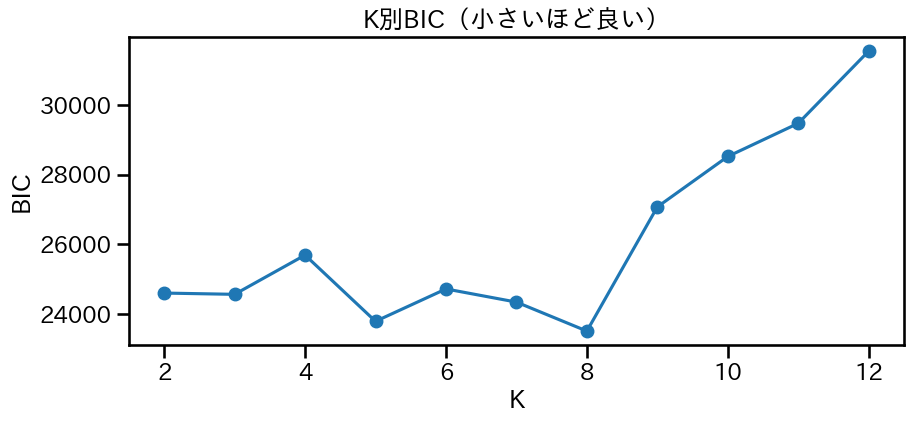

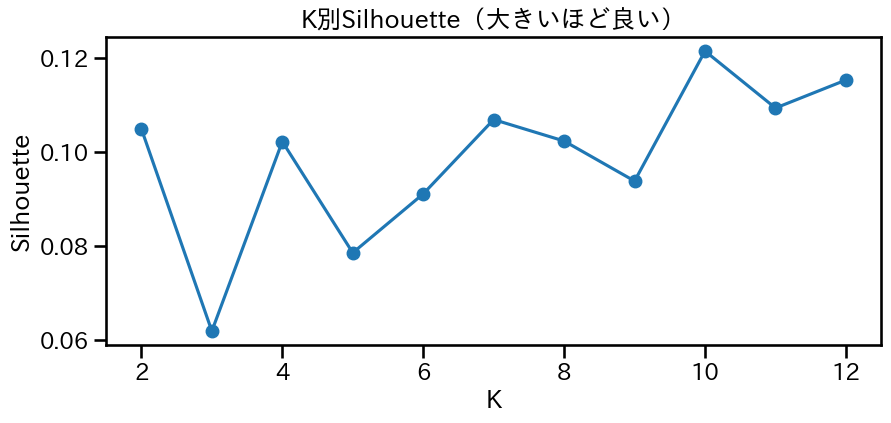

saved: k_selection_table.csv


In [60]:
K_RANGE = range(2, 13)

rows = []
models = {}
for k in K_RANGE:
    gmm = GaussianMixture(
        n_components=k, covariance_type="full",
        random_state=RANDOM_STATE, n_init=10
    )
    gmm.fit(Xz)
    ll = gmm.score(Xz)  # 平均対数尤度（大きいほど良い）
    bic = gmm.bic(Xz)
    aic = gmm.aic(Xz)
    # Silhouetteはクラスタが1つになると計算不能だがK>=2なのでOK
    labels = gmm.predict(Xz)
    sil = silhouette_score(Xz, labels)

    rows.append({"K": k, "BIC": bic, "AIC": aic, "LogLik(mean)": ll, "Silhouette": sil})
    models[k] = gmm

k_table = pd.DataFrame(rows).sort_values("BIC").reset_index(drop=True)
display(k_table)

best_k = int(k_table.iloc[0]["K"])
best_gmm = models[best_k]
print("★最適K（BIC最小）=", best_k)

# 可視化
plt.figure(figsize=(10,4))
plt.plot(k_table.sort_values("K")["K"], k_table.sort_values("K")["BIC"], marker="o")
plt.title("K別BIC（小さいほど良い）")
plt.xlabel("K"); plt.ylabel("BIC"); plt.show()

plt.figure(figsize=(10,4))
plt.plot(k_table.sort_values("K")["K"], k_table.sort_values("K")["Silhouette"], marker="o")
plt.title("K別Silhouette（大きいほど良い）")
plt.xlabel("K"); plt.ylabel("Silhouette"); plt.show()

k_table.to_csv("k_selection_table.csv", index=False, encoding="utf-8-sig")
print("saved: k_selection_table.csv")


In [61]:
def posterior_entropy(resp, eps=1e-12):
    r = np.clip(resp, eps, 1.0)
    return -(r * np.log(r)).sum(axis=1)

# 予測
df["state"] = best_gmm.predict(Xz)
df["log_likelihood"] = best_gmm.score_samples(Xz)
resp = best_gmm.predict_proba(Xz)
df["entropy"] = posterior_entropy(resp)

alpha = 0.05  # 5%
thr_ll  = np.quantile(df["log_likelihood"], alpha)
thr_ent = np.quantile(df["entropy"], 1-alpha)

anoms_ll  = df[df["log_likelihood"] <= thr_ll].copy()
anoms_ent = df[df["entropy"] >= thr_ent].copy()

print("尤度下位(特異点A) 件数:", len(anoms_ll), " / entropy上位(特異点B) 件数:", len(anoms_ent))

keyA = set(zip(anoms_ll["chapter"], anoms_ll["span_id"]))
keyB = set(zip(anoms_ent["chapter"], anoms_ent["span_id"]))
both = keyA & keyB
print("共通（A∩B）件数:", len(both))

# 保存
anoms_ll.sort_values("log_likelihood").to_csv("anomalies_loglik.csv", index=False, encoding="utf-8-sig")
anoms_ent.sort_values("entropy", ascending=False).to_csv("anomalies_entropy.csv", index=False, encoding="utf-8-sig")
print("saved: anomalies_loglik.csv / anomalies_entropy.csv")


尤度下位(特異点A) 件数: 28  / entropy上位(特異点B) 件数: 28
共通（A∩B）件数: 1
saved: anomalies_loglik.csv / anomalies_entropy.csv


In [62]:
# =========================================================
# STATE表（凡例）を作る（頻度・プロファイル・代表evidence）
# =========================================================

import numpy as np
import pandas as pd

# --- 0) 表示用に state を 1始まりにも用意（必要なら）
df["state_1based"] = df["state"].astype(int) + 1

K = resp.shape[1]  # 状態数

# --- 1) State頻度表
state_counts = (
    df["state"].value_counts()
      .sort_index()
      .rename_axis("state")
      .reset_index(name="count")
)
state_counts["state_1based"] = state_counts["state"] + 1
display(state_counts)
state_counts.to_csv("state_counts_table.csv", index=False, encoding="utf-8-sig")
print("saved: state_counts_table.csv")

# --- 2) Stateプロファイル（Z空間：Xz の state 別平均）
zcols = [f"{c}__z" for c in feature_cols]
df_z = pd.DataFrame(Xz, columns=zcols)
df_z["state"] = df["state"].astype(int).values

state_profile_z = df_z.groupby("state")[zcols].mean().sort_index()
state_profile_z.to_csv("state_profile_z_table.csv", encoding="utf-8-sig")
print("saved: state_profile_z_table.csv")

# --- 2.1) 各Stateの「上位特徴」TopN（凡例の核）
TOPN = 8
rows = []
for k in range(K):
    s = state_profile_z.loc[k]
    top = s.reindex(s.abs().sort_values(ascending=False).head(TOPN).index)
    rows.append({
        "state": k,
        "state_1based": k + 1,
        "top_features": "; ".join([f"{name.replace('__z','')}={val:+.2f}" for name, val in top.items()])
    })
state_topfeat = pd.DataFrame(rows)
display(state_topfeat)
state_topfeat.to_csv("state_top_features_table.csv", index=False, encoding="utf-8-sig")
print("saved: state_top_features_table.csv")

# --- 2.2) 自動ラベル案（※最終的にはあなたが編集して確定する前提）
def suggest_label_from_top(top_feature_str: str) -> str:
    s = top_feature_str
    if "mode_dialogue" in s:
        return "対話・相互作用"
    if "mode_perception" in s:
        return "外界知覚・描写"
    if ("mode_inner_speech" in s) or ("mode_reasoning" in s):
        return "内的独白・推論"
    if "mode_memory" in s:
        return "記憶想起"
    if "mode_imagination" in s:
        return "想像・仮想"
    if ("mode_quotation" in s) or ("cause_intertext" in s) or ("style_intertext_density" in s):
        return "引用・間テキスト"
    return "混合（要解釈）"

state_legend = state_topfeat.copy()
state_legend["label_suggested_ja"] = state_legend["top_features"].apply(suggest_label_from_top)
display(state_legend)
state_legend.to_csv("state_legend_table.csv", index=False, encoding="utf-8-sig")
print("saved: state_legend_table.csv")

# --- 3) State代表evidence（各Stateで「そのState確率が高い」もの上位）
# resp[i,k] を使って「代表的な点」を拾う
rep_rows = []
for k in range(K):
    pk = resp[:, k]
    idx = np.argsort(-pk)[:3]  # 上位3件（好みで増やせます）
    for rank, i in enumerate(idx, start=1):
        rep_rows.append({
            "state": k,
            "state_1based": k + 1,
            "rank_in_state": rank,
            "p_state": float(pk[i]),
            "entropy": float(df.loc[i, "entropy"]),
            "log_likelihood": float(df.loc[i, "log_likelihood"]),
            "chapter": df.loc[i, "chapter"],
            "span_id": df.loc[i, "span_id"],
            "evidence": df.loc[i, "evidence"] if "evidence" in df.columns else "",
        })
state_examples = pd.DataFrame(rep_rows)
display(state_examples.head(12))
state_examples.to_csv("state_examples_table.csv", index=False, encoding="utf-8-sig")
print("saved: state_examples_table.csv")

print("DONE: STATE凡例セット（counts/profile/topfeat/legend/examples）を出力しました。")


,state,count,state_1based
0,0,108,1
1,1,124,2
2,2,114,3
3,3,81,4
4,4,65,5
5,5,45,6
6,6,7,7
7,7,11,8


saved: state_counts_table.csv
saved: state_profile_z_table.csv


,state,state_1based,top_features
0,0,1,cause_intertext=+1.29; mode_quotation=+1.29; s...
1,1,2,place_1=+0.98; mode_dialogue=+0.86; cause_soci...
2,2,3,cause_goal_task=+0.95; mode_reasoning=+0.74; m...
3,3,4,myth_1=+1.12; cause_memory=+0.81; mode_memory=...
4,4,5,place_0=+1.53; cause_sensory=+1.07; mode_perce...
5,5,6,place_2=+2.30; mode_inner_speech=+2.17; style_...
6,6,7,style_ellipsis=+7.78; place_2=+1.01; cause_emo...
7,7,8,myth_3=+4.44; mode_dialogue=+2.34; place_1=+1....


saved: state_top_features_table.csv


,state,state_1based,top_features,label_suggested_ja
0,0,1,cause_intertext=+1.29; mode_quotation=+1.29; s...,想像・仮想
1,1,2,place_1=+0.98; mode_dialogue=+0.86; cause_soci...,対話・相互作用
2,2,3,cause_goal_task=+0.95; mode_reasoning=+0.74; m...,外界知覚・描写
3,3,4,myth_1=+1.12; cause_memory=+0.81; mode_memory=...,記憶想起
4,4,5,place_0=+1.53; cause_sensory=+1.07; mode_perce...,対話・相互作用
5,5,6,place_2=+2.30; mode_inner_speech=+2.17; style_...,内的独白・推論
6,6,7,style_ellipsis=+7.78; place_2=+1.01; cause_emo...,内的独白・推論
7,7,8,myth_3=+4.44; mode_dialogue=+2.34; place_1=+1....,対話・相互作用


saved: state_legend_table.csv


,state,state_1based,rank_in_state,p_state,entropy,log_likelihood,chapter,span_id,evidence
0,0,1,1,1.0,1.934171e-10,-14.424805,1,23,
1,0,1,2,1.0,1.934171e-10,-12.614727,1,24,
2,0,1,3,1.0,1.934171e-10,-13.459415,17,22,
3,1,2,1,1.0,1.934171e-10,-3.416519,16,29,
4,1,2,2,1.0,1.934171e-10,-1.717001,16,23,
5,1,2,3,1.0,1.934171e-10,2.716513,15,47,
6,2,3,1,1.0,1.934171e-10,-7.464165,1,1,
7,2,3,2,1.0,1.934171e-10,6.242627,17,28,
8,2,3,3,1.0,1.934171e-10,4.708762,17,27,
9,3,4,1,1.0,1.934171e-10,-10.746709,2,5,


saved: state_examples_table.csv
DONE: STATE凡例セット（counts/profile/topfeat/legend/examples）を出力しました。


In [63]:
SEEDS = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]

ref_labels = df["state"].to_numpy()
ref_boundary = set(zip(anoms_ent["chapter"], anoms_ent["span_id"]))  # entropy上位をboundaryの代表に

def jaccard(a, b):
    if len(a | b) == 0: return 1.0
    return len(a & b) / len(a | b)

stab_rows = []
for s in SEEDS:
    g = GaussianMixture(n_components=best_k, covariance_type="full", random_state=s, n_init=10)
    g.fit(Xz)
    lab = g.predict(Xz)
    ari = adjusted_rand_score(ref_labels, lab)

    ent = posterior_entropy(g.predict_proba(Xz))
    thr = np.quantile(ent, 1-alpha)
    bd = set(zip(df.loc[ent >= thr, "chapter"], df.loc[ent >= thr, "span_id"]))
    jac = jaccard(ref_boundary, bd)

    stab_rows.append({"seed": s, "ARI_vs_ref": ari, "Jaccard_boundary_vs_ref": jac})

stab = pd.DataFrame(stab_rows)
display(stab)

print("ARI 平均:", stab["ARI_vs_ref"].mean(), " / boundary Jaccard 平均:", stab["Jaccard_boundary_vs_ref"].mean())
stab.to_csv("stability_table.csv", index=False, encoding="utf-8-sig")
print("saved: stability_table.csv")


,seed,ARI_vs_ref,Jaccard_boundary_vs_ref
0,0,0.608097,0.166667
1,1,0.321983,0.037037
2,2,0.550070,0.166667
3,3,0.337499,0.076923
4,4,0.436716,0.076923
5,5,0.453962,0.076923
6,6,0.385457,0.076923
7,7,0.535643,0.142857
8,8,0.348592,0.018182
9,9,0.450878,0.142857


ARI 平均: 0.442889678625244  / boundary Jaccard 平均: 0.0981958781958782
saved: stability_table.csv


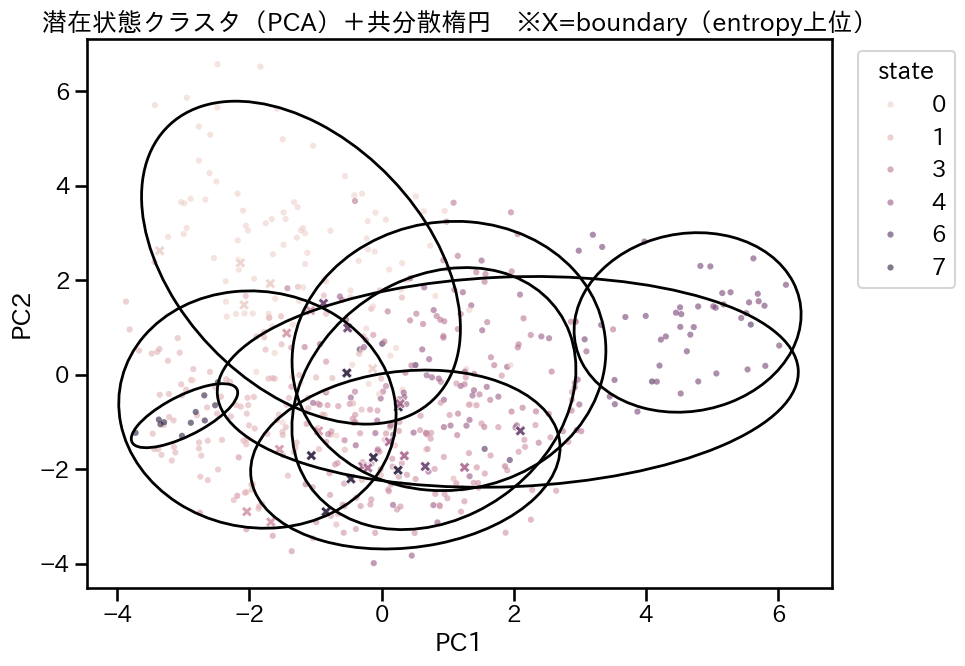

saved: fig_cluster_pca_ellipse.png


In [64]:
from matplotlib.patches import Ellipse

def cov_ellipse(mean, cov, n_std=2.0):
    # 2x2 covariance → ellipse
    vals, vecs = np.linalg.eigh(cov)
    order = vals.argsort()[::-1]
    vals, vecs = vals[order], vecs[:, order]
    theta = np.degrees(np.arctan2(*vecs[:,0][::-1]))
    width, height = 2 * n_std * np.sqrt(vals)
    return width, height, theta

# PCAで2次元へ
pca = PCA(n_components=2, random_state=RANDOM_STATE)
Z = pca.fit_transform(Xz)
df["pc1"], df["pc2"] = Z[:,0], Z[:,1]

# boundary点（entropy上位）
is_boundary = df["entropy"] >= np.quantile(df["entropy"], 1-alpha)

plt.figure(figsize=(10,7))
# 点：通常
sns.scatterplot(data=df[~is_boundary], x="pc1", y="pc2", hue="state", s=20, linewidth=0, alpha=0.6)
# 点：boundary
sns.scatterplot(data=df[is_boundary], x="pc1", y="pc2", hue="state", s=60, marker="X", linewidth=0.6, alpha=0.9, legend=False)

# 楕円（クラスタごと）
for k in range(best_k):
    pts = df[df["state"]==k][["pc1","pc2"]].to_numpy()
    if len(pts) < 5:
        continue
    mu = pts.mean(axis=0)
    cov = np.cov(pts.T)
    w,h,theta = cov_ellipse(mu, cov, n_std=2.0)
    e = Ellipse(xy=mu, width=w, height=h, angle=theta, fill=False, lw=2)
    plt.gca().add_patch(e)

plt.title("潜在状態クラスタ（PCA）＋共分散楕円　※X=boundary（entropy上位）")
plt.xlabel("PC1"); plt.ylabel("PC2")
plt.legend(title="state", bbox_to_anchor=(1.02,1), loc="upper left")
plt.tight_layout()
plt.savefig("fig_cluster_pca_ellipse.png", dpi=200)
plt.show()

print("saved: fig_cluster_pca_ellipse.png")


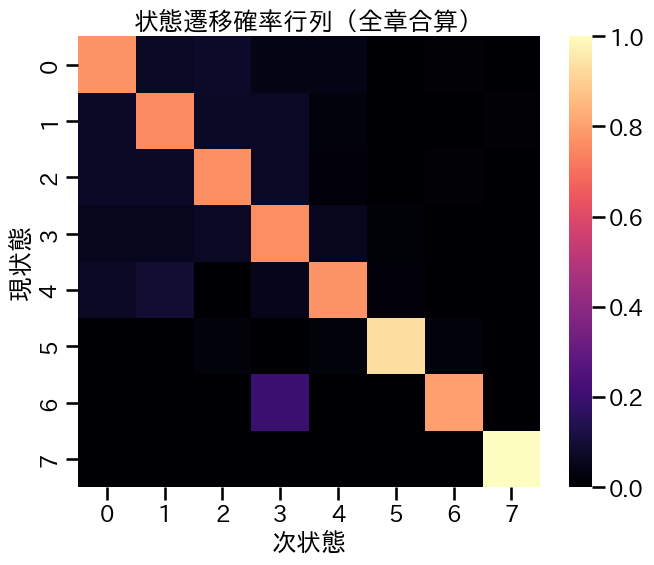

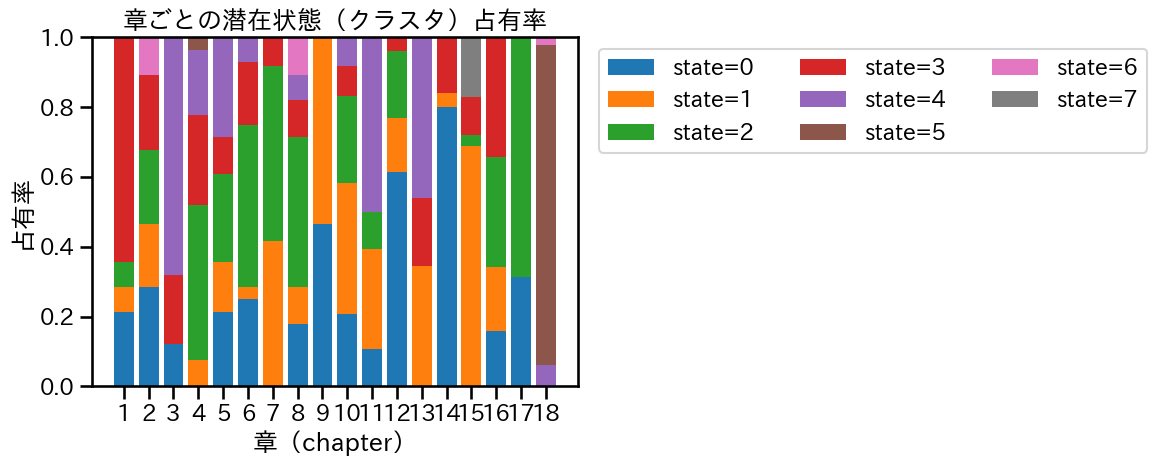

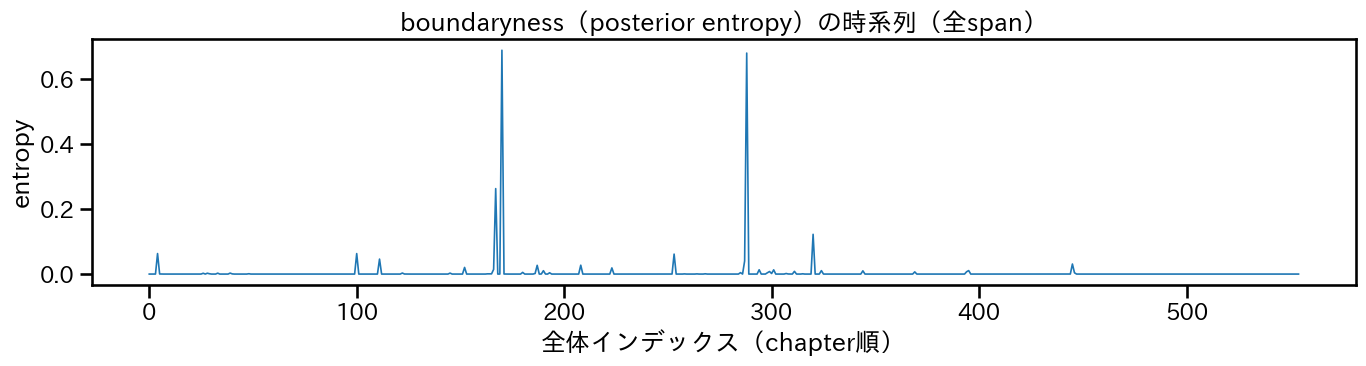

saved: fig_transition_matrix.png / fig_chapter_cluster_share.png / fig_entropy_timeseries.png


In [65]:
# ---- 遷移行列 ----
K = best_k
trans = np.zeros((K, K), dtype=float)
for _, g in df.groupby("chapter"):
    s = g.sort_values("span_id")["state"].to_numpy()
    for a, b in zip(s[:-1], s[1:]):
        trans[a, b] += 1
trans_prob = trans / np.maximum(trans.sum(axis=1, keepdims=True), 1)

plt.figure(figsize=(7,6))
sns.heatmap(trans_prob, cmap="magma", vmin=0, vmax=1)
plt.title("状態遷移確率行列（全章合算）")
plt.xlabel("次状態"); plt.ylabel("現状態")
plt.tight_layout()
plt.savefig("fig_transition_matrix.png", dpi=200)
plt.show()

# ---- 章別占有率（積み上げ）----
dist = df.groupby(["chapter","state"]).size().unstack(fill_value=0).sort_index()
dist_rate = dist.div(dist.sum(axis=1), axis=0)

plt.figure(figsize=(12,5))
bottom = np.zeros(len(dist_rate))
x = np.arange(len(dist_rate.index))
for s in dist_rate.columns:
    plt.bar(x, dist_rate[s].values, bottom=bottom, label=f"state={s}")
    bottom += dist_rate[s].values
plt.xticks(x, dist_rate.index)
plt.title("章ごとの潜在状態（クラスタ）占有率")
plt.xlabel("章（chapter）"); plt.ylabel("占有率")
plt.legend(ncol=3, bbox_to_anchor=(1.02, 1), loc="upper left")
plt.tight_layout()
plt.savefig("fig_chapter_cluster_share.png", dpi=200)
plt.show()

# ---- boundaryness（entropy）時系列 ----
plt.figure(figsize=(14,4))
plt.plot(df["entropy"].to_numpy(), lw=1.2)
plt.title("boundaryness（posterior entropy）の時系列（全span）")
plt.xlabel("全体インデックス（chapter順）"); plt.ylabel("entropy")
plt.tight_layout()
plt.savefig("fig_entropy_timeseries.png", dpi=200)
plt.show()

print("saved: fig_transition_matrix.png / fig_chapter_cluster_share.png / fig_entropy_timeseries.png")


,n,r,CI95%,p-val
pearson,555,0.022155,"[-0.06, 0.11]",0.602814


,n,r,CI95%,p-val
pearson,555,0.000184,"[-0.08, 0.08]",0.996558


,n,r,CI95%,p-val
pearson,555,0.042056,"[-0.04, 0.12]",0.32311


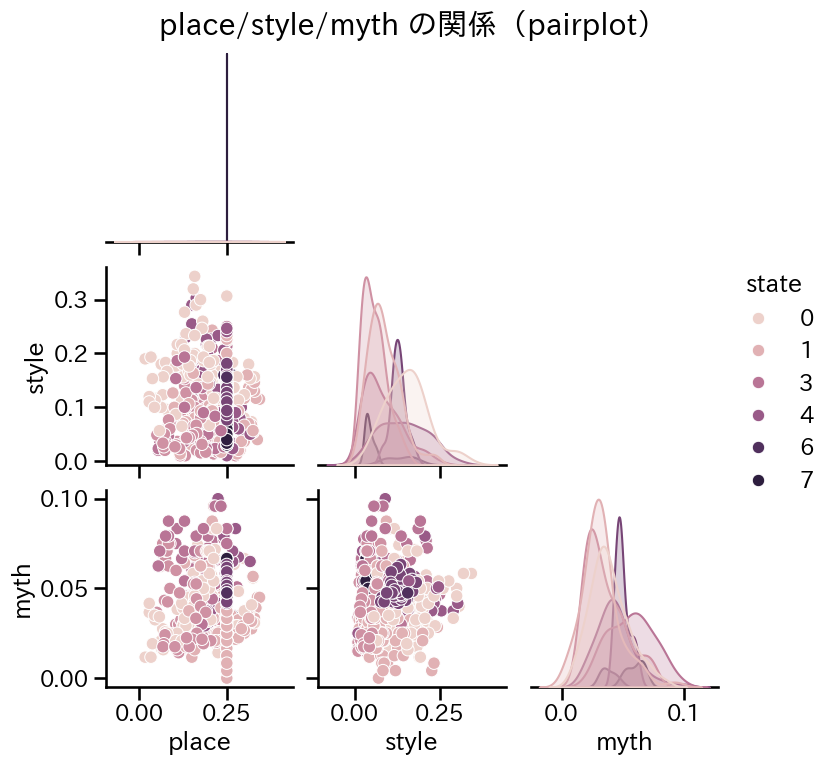

saved: fig_pairplot_layers.png / partial_corr_table.csv


In [66]:
def mean_prefix(prefix):
    cols = [c for c in df.columns if c.startswith(prefix)]
    return df[cols].mean(axis=1) if cols else None

df_corr = pd.DataFrame({
    "place": mean_prefix("place_"),
    "style": mean_prefix("style_"),
    "myth":  mean_prefix("myth_"),
    "chapter": df["chapter"].astype(int),
    "state": df["state"].astype(int),
}).dropna()

import pingouin as pg

pc1 = pg.partial_corr(df_corr, x="place", y="style", covar=["chapter"])
pc2 = pg.partial_corr(df_corr, x="place", y="myth",  covar=["chapter"])
pc3 = pg.partial_corr(df_corr, x="style", y="myth",  covar=["chapter"])

display(pc1); display(pc2); display(pc3)

sns.pairplot(df_corr[["place","style","myth","state"]], hue="state", corner=True)
plt.suptitle("place/style/myth の関係（pairplot）", y=1.02)
plt.savefig("fig_pairplot_layers.png", dpi=200)
plt.show()

pc_all = pd.concat([
    pc1.assign(pair="place-style"),
    pc2.assign(pair="place-myth"),
    pc3.assign(pair="style-myth"),
], ignore_index=True)
pc_all.to_csv("partial_corr_table.csv", index=False, encoding="utf-8-sig")
print("saved: fig_pairplot_layers.png / partial_corr_table.csv")


In [67]:
ALPHAS = [0.01, 0.03, 0.05, 0.10]

rows = []
for a in ALPHAS:
    thr_ll  = np.quantile(df["log_likelihood"], a)
    thr_ent = np.quantile(df["entropy"], 1-a)
    n_ll  = int((df["log_likelihood"] <= thr_ll).sum())
    n_ent = int((df["entropy"] >= thr_ent).sum())
    # 章別のboundary密度（entropy系）
    bd = df["entropy"] >= thr_ent
    by_ch = df.loc[bd].groupby("chapter").size()
    density_mean = (by_ch / df.groupby("chapter").size()).mean()  # 章内比率の平均
    rows.append({"alpha": a, "n_anom_loglik": n_ll, "n_boundary_entropy": n_ent, "mean_boundary_density_per_ch": density_mean})

alpha_table = pd.DataFrame(rows)
display(alpha_table)
alpha_table.to_csv("alpha_sensitivity_table.csv", index=False, encoding="utf-8-sig")
print("saved: alpha_sensitivity_table.csv")


,alpha,n_anom_loglik,n_boundary_entropy,mean_boundary_density_per_ch
0,0.01,6,6,0.046052
1,0.03,17,17,0.057666
2,0.05,28,28,0.072213
3,0.10,56,56,0.136322


saved: alpha_sensitivity_table.csv


In [68]:
# レポート本文（Markdown）を生成して、図と表のファイル名を埋め込みます
summary = {
    "rows": len(df),
    "cols": len(df.columns),
    "features": len(feature_cols),
    "best_k": best_k,
    "alpha": alpha,
    "anom_loglik": int((df["log_likelihood"] <= np.quantile(df["log_likelihood"], alpha)).sum()),
    "anom_entropy": int((df["entropy"] >= np.quantile(df["entropy"], 1-alpha)).sum()),
    "stability_ari_mean": float(stab["ARI_vs_ref"].mean()),
    "stability_jacc_mean": float(stab["Jaccard_boundary_vs_ref"].mean()),
}

md = f"""# 『ユリシーズ』意識流 潜在状態・遷移・特異点解析（GMM）

## 実行サマリー
- データ行数: {summary["rows"]}
- 特徴量数: {summary["features"]}
- 最適K（BIC最小）: {summary["best_k"]}
- alpha: {summary["alpha"]}
- 特異点（尤度下位）件数: {summary["anom_loglik"]}
- boundary（entropy上位）件数: {summary["anom_entropy"]}
- 安定性（seed反復）ARI平均: {summary["stability_ari_mean"]:.3f}
- 安定性（boundary Jaccard平均）: {summary["stability_jacc_mean"]:.3f}

## 1. K選択
- `k_selection_table.csv` を参照（BIC/AIC/Silhouette）

## 2. クラスタ散布（PCA＋楕円）
![](fig_cluster_pca_ellipse.png)

## 3. 状態遷移行列
![](fig_transition_matrix.png)

## 4. 章別クラスタ占有率
![](fig_chapter_cluster_share.png)

## 5. boundaryness（entropy）時系列
![](fig_entropy_timeseries.png)

## 6. 多層レイヤー関係（偏相関・pairplot）
- `partial_corr_table.csv` を参照
![](fig_pairplot_layers.png)

## 7. 特異点出力
- 尤度系: `anomalies_loglik.csv`
- entropy系: `anomalies_entropy.csv`

## 8. 感度分析
- `alpha_sensitivity_table.csv` を参照
"""

open("ulysses_gmm_report.md", "w", encoding="utf-8").write(md)
print("saved: ulysses_gmm_report.md")


saved: ulysses_gmm_report.md


In [69]:
import json
import numpy as np
import pandas as pd
from sklearn.mixture import GaussianMixture
from sklearn.preprocessing import StandardScaler

CSV_PATH = "/content/ulysses_stream.csv"
JSON_PATH = "/content/Ulysses_fixed.json"

K = 8
ALPHA = 0.05  # boundary候補にする上位割合（例: 0.05=上位5%）
SEED = 0

# ---------------------------
# helper: evidence取得（ja優先）
# ---------------------------
def pick_evidence(row: pd.Series) -> str:
    """Prefer Japanese evidence if available, else fall back safely."""
    for col in ["evidence_ja", "evidence_en", "evidence", "quote", "text", "raw_text"]:
        if col in row.index:
            v = row[col]
            if isinstance(v, str) and v.strip():
                return v.strip()
    return ""

# ---------------------------
# 1) CSVロード（29 features想定）
# ---------------------------
df = pd.read_csv(CSV_PATH)

feature_cols = [
    c for c in df.columns
    if c.startswith("mode_")
    or c.startswith("cause_")
    or c.startswith("place_")
    or c.startswith("myth_")
    or c.startswith("style_")
]
X = df[feature_cols].to_numpy()

# ---------------------------
# 2) GMM -> posterior -> entropy
# ---------------------------
Xz = StandardScaler().fit_transform(X)
gmm = GaussianMixture(
    n_components=K,
    covariance_type="diag",
    random_state=SEED,
    reg_covar=1e-6,
    max_iter=500,
    n_init=10
)
gmm.fit(Xz)
resp = gmm.predict_proba(Xz)

entropy = -(resp * np.log(resp + 1e-12)).sum(axis=1)

gmm_state = resp.argmax(axis=1)          # 0-based
gmm_state_1based = gmm_state + 1         # 1-based（論文向け）
state_change = np.r_[False, gmm_state[1:] != gmm_state[:-1]]

# Top2 state と margin（転調点の説明で使える）
order = np.argsort(-resp, axis=1)        # desc
s1 = order[:, 0]
s2 = order[:, 1]
p1 = resp[np.arange(len(df)), s1]
p2 = resp[np.arange(len(df)), s2]
margin = p1 - p2

# ---------------------------
# 3) boundary候補：entropy 上位ALPHA%
# ---------------------------
n_top = int(np.ceil(len(df) * ALPHA))
top_idx = np.argsort(entropy)[-n_top:][::-1]  # entropy大きい順

# ---------------------------
# 4) JSON側も索引化（episode+global_step で引けるように）
# ---------------------------
with open(JSON_PATH, "r", encoding="utf-8") as f:
    js = json.load(f)

# js が chapter配列 or span配列のどちらでも動くようにフラット化
spans = []
if isinstance(js, list):
    # 章配列の可能性
    for item in js:
        if isinstance(item, dict) and "time_series_data" in item:
            spans.extend(item.get("time_series_data", []))
        else:
            spans.append(item)
elif isinstance(js, dict):
    spans = js.get("time_series_data", [])
else:
    spans = []

index = {}
for s in spans:
    ep = s.get("episode")
    gs = s.get("global_step")
    if ep is not None and gs is not None:
        try:
            index[(int(ep), int(gs))] = s
        except Exception:
            pass

# ---------------------------
# 5) boundary レポート（前後evidenceも付与）
# ---------------------------
rows = []
for i in top_idx:
    ch = int(df.loc[i, "chapter"]) if "chapter" in df.columns else -1
    sid = int(df.loc[i, "span_id"]) if "span_id" in df.columns else int(i)
    tt = df.loc[i, "transition_type"] if "transition_type" in df.columns else ""

    # evidenceは ja/en どちらでも拾えるようにする
    ev = pick_evidence(df.loc[i])
    ev_prev = pick_evidence(df.loc[i - 1]) if i - 1 >= 0 else ""
    ev_next = pick_evidence(df.loc[i + 1]) if i + 1 < len(df) else ""

    # NOTE:
    # episode/global_step がCSVに無い場合は chapter/span_id を仮キーとして使う
    # ここでは「chapter=episode, span_id=global_step」を仮定（あなたの整形に合わせて要変更）
    s = index.get((ch, sid), {})

    rows.append({
        "row_index": int(i),
        "chapter": ch,
        "span_id": sid,
        "transition_type": tt,
        "entropy": float(entropy[i]),
        "gmm_state": int(gmm_state[i]),
        "gmm_state_1based": int(gmm_state_1based[i]),
        "state_change": bool(state_change[i]),
        "top1_state_1based": int(s1[i] + 1),
        "top1_p": float(p1[i]),
        "top2_state_1based": int(s2[i] + 1),
        "top2_p": float(p2[i]),
        "margin": float(margin[i]),
        "evidence_prev": ev_prev,
        "evidence": ev,
        "evidence_next": ev_next,
        "json_span_text_en": s.get("span_text_en", ""),
        "json_span_text_ja": s.get("span_text_ja", ""),
    })

rep = pd.DataFrame(rows)

# 文字数が長すぎて表が崩れる場合は短縮（任意）
# MAXLEN = 160
# for c in ["evidence_prev", "evidence", "evidence_next"]:
#     if c in rep.columns:
#         rep[c] = rep[c].astype(str).str.replace("\n", " ").str.slice(0, MAXLEN)

rep.to_csv("boundary_report.csv", index=False, encoding="utf-8-sig")
print("saved: boundary_report.csv")

# ---------------------------
# 6) 転調点 Top10（本文掲載用）※衝突ゼロ版
# ---------------------------
# 既存dfの列衝突を完全回避するため、Top10用DFを“新規構築”する

TOPK = 10

tp = pd.DataFrame({
    "chapter": df["chapter"].astype(int) if "chapter" in df.columns else pd.Series([-1]*len(df)),
    "span_id": df["span_id"].astype(int) if "span_id" in df.columns else pd.Series(np.arange(len(df))),
    "transition_type": df["transition_type"] if "transition_type" in df.columns else "",
    "entropy": entropy,
    "gmm_state_1based": (gmm_state + 1).astype(int),
    "top1_state_1based": (s1 + 1).astype(int),
    "top1_p": p1.astype(float),
    "top2_state_1based": (s2 + 1).astype(int),
    "top2_p": p2.astype(float),
    "margin": margin.astype(float),
    "evidence_best": df.apply(pick_evidence, axis=1),
})

# entropy降順、同点のとき margin小（=混合が強い）を優先
tp = tp.sort_values(["entropy", "margin"], ascending=[False, True]).copy()

# （任意）global_stepがある場合は重複排除したいならここをON
# if "global_step" in df.columns:
#     tp["global_step"] = df["global_step"].astype(int)
#     tp = tp.drop_duplicates(subset=["global_step"], keep="first")

tp10_out = tp.head(TOPK).copy()
tp10_out.insert(0, "rank", np.arange(1, len(tp10_out) + 1))

tp10_out.to_csv("turning_points_top10.csv", index=False, encoding="utf-8-sig")
tp10_out.to_csv("turning_points_top10.tsv", index=False, sep="\t", encoding="utf-8-sig")

print("saved: turning_points_top10.csv / turning_points_top10.tsv")
display(tp10_out)

print("sanity check (should be 1..K):",
      int(tp10_out["gmm_state_1based"].min()),
      int(tp10_out["gmm_state_1based"].max()))


saved: boundary_report.csv
saved: turning_points_top10.csv / turning_points_top10.tsv


,rank,chapter,span_id,transition_type,entropy,gmm_state_1based,top1_state_1based,top1_p,top2_state_1based,top2_p,margin,evidence_best
172,1,7,9,rumination,0.693457,2,2,0.502376,4,0.497594,0.004782,疑問文＋「Thumping」反復で作業音が思考に食い込む。
280,2,11,13,semantic_association,0.685999,4,4,0.559711,2,0.440289,0.119423,視覚（eye）＋読字（read）。
173,3,7,10,semantic_association,0.554764,5,5,0.837654,2,0.091454,0.746200,断片文が連なり、内言の流れが優位。
292,4,11,25,semantic_association,0.536416,4,4,0.772354,7,0.227646,0.544708,By の反復で列挙リズムが支配。
502,5,17,28,semantic_association,0.534026,7,7,0.774302,2,0.225698,0.548604,"聴覚入力（sound, chime）でアンカーが補強。"
31,6,2,4,intrusion,0.399937,4,4,0.876068,5,0.117514,0.758554,I hear から連鎖する感覚-像の急激な挿入。
346,7,13,25,script_switch,0.391869,7,7,0.867105,4,0.132894,0.734211,固有名の提示と姿勢描写により script_switch と social/emotion ...
178,8,7,15,semantic_association,0.362360,2,2,0.882283,4,0.117716,0.764567,「Reads」「Quickly」「practice」で観察→推測が同一流れ。
126,9,5,19,rumination,0.349407,5,5,0.888612,8,0.111388,0.777224,「Poor papa!」の感嘆から過去行為（didn’t go）へ移る。
514,10,18,8,contrast,0.338288,8,8,0.893897,5,0.106103,0.787795,「polite」＋対人対象の列挙。


sanity check (should be 1..K): 2 8


In [70]:
print(tp10_out.columns.tolist())


['rank', 'chapter', 'span_id', 'transition_type', 'entropy', 'gmm_state_1based', 'top1_state_1based', 'top1_p', 'top2_state_1based', 'top2_p', 'margin', 'evidence_best']


In [71]:
import numpy as np
import pandas as pd

# =========================
# 0) 設定
# =========================
FULL_PATH = "entropy_ambiguity_full.csv"   # 既に保存したファイル
TOPK  = 30
RANDK = 30
SEED  = 42

# どっちつかず（拮抗）の閾値：固定値 or 分位点
USE_QUANTILE_MARGIN = True
MARGIN_Q = 0.2          # 下位20%を拮抗扱い
MARGIN_THR_FIXED = 0.15 # 固定で使うならこちら

# 代表例として抜き出す件数
EXAMPLES_PER_PAIR = 3

# CSV出力
OUT_PREFIX = "modepair_test"
# =========================

df = pd.read_csv(FULL_PATH)

# 必須列チェック
need = ["entropy", "margin", "top1_mode", "top2_mode"]
miss = [c for c in need if c not in df.columns]
if miss:
    raise ValueError(f"missing columns in {FULL_PATH}: {miss}")

# 数値化
df["entropy"] = pd.to_numeric(df["entropy"], errors="coerce")
df["margin"]  = pd.to_numeric(df["margin"], errors="coerce")

# 文字列化（NaN対策）
df["top1_mode"] = df["top1_mode"].astype(str).fillna("")
df["top2_mode"] = df["top2_mode"].astype(str).fillna("")

# 便利列（モードペアを順序なしでまとめる：perception-inner_speech と inner_speech-perception を同一扱い）
def unordered_pair(a, b):
    a = str(a); b = str(b)
    if a <= b:
        return f"{a}__{b}"
    else:
        return f"{b}__{a}"

df["mode_pair_unordered"] = [unordered_pair(a,b) for a,b in zip(df["top1_mode"], df["top2_mode"])]

# 競合（モードが異なる）
df["mode_conflict"] = (df["top1_mode"] != df["top2_mode"])

# margin閾値
if USE_QUANTILE_MARGIN:
    margin_thr = float(df["margin"].quantile(MARGIN_Q))
else:
    margin_thr = float(MARGIN_THR_FIXED)

# 曖昧（競合かつ拮抗）
df["ambiguous_internal"] = df["mode_conflict"] & (df["margin"] <= margin_thr)

print(f"[threshold] margin_thr = {margin_thr:.6g}  (USE_QUANTILE_MARGIN={USE_QUANTILE_MARGIN})")

# =========================
# 1) TopK と RandomK を作る
# =========================
df_sorted = df.sort_values(["entropy", "margin"], ascending=[False, True]).reset_index(drop=True)
top = df_sorted.head(TOPK).copy()

rest = df_sorted.iloc[TOPK:].copy()
rng = np.random.default_rng(SEED)
rand_idx = rng.choice(rest.index.to_numpy(), size=min(RANDK, len(rest)), replace=False)
rnd = rest.loc[rand_idx].copy()

top["group"] = "Top"
rnd["group"] = "Random"

sub = pd.concat([top, rnd], axis=0, ignore_index=True)

# =========================
# 2) 2×2表 + Fisher（全体）
# =========================
from scipy.stats import fisher_exact

a = int(top["ambiguous_internal"].sum())
b = int(len(top) - a)
c = int(rnd["ambiguous_internal"].sum())
d = int(len(rnd) - c)

table = pd.DataFrame(
    [[a,b],[c,d]],
    index=[f"Top{TOPK}", f"Random{RANDK}"],
    columns=["ambiguous=1", "ambiguous=0"]
)

odds, p = fisher_exact([[a,b],[c,d]], alternative="two-sided")
print("\n=== Overall 2×2 contingency table (internal definition) ===")
display(table)
print(f"Top ambiguous率: {a/max(1,a+b):.3f} ({a}/{a+b})")
print(f"Rnd ambiguous率: {c/max(1,c+d):.3f} ({c}/{c+d})")
print(f"Fisher two-sided p = {p:.6g} | odds ratio = {odds}")

# 保存
table.to_csv(f"{OUT_PREFIX}_overall_2x2.csv", encoding="utf-8-sig")

# =========================
# 3) モードペア混同行列（Top / Random）
#    - unorderedペアで集計
# =========================
pair_counts = (
    sub.groupby(["group", "mode_pair_unordered"])
       .size()
       .unstack(fill_value=0)
       .sort_index(axis=1)
)

# 率（行ごとに正規化）
pair_rates = pair_counts.div(pair_counts.sum(axis=1), axis=0)

print("\n=== Mode-pair counts (unordered) ===")
display(pair_counts)

print("\n=== Mode-pair rates (unordered) ===")
display(pair_rates)

pair_counts.to_csv(f"{OUT_PREFIX}_pair_counts.csv", encoding="utf-8-sig")
pair_rates.to_csv(f"{OUT_PREFIX}_pair_rates.csv", encoding="utf-8-sig")

# =========================
# 4) ペアごとの増減と簡易検定（Fisher per pair）
#    ※多重比較は参考値。論文では「探索的」と明記推奨。
# =========================
rows = []
N_top = len(top)
N_rnd = len(rnd)

all_pairs = sorted(set(pair_counts.columns))

for pair in all_pairs:
    x_top = int(pair_counts.loc["Top", pair]) if "Top" in pair_counts.index else 0
    x_rnd = int(pair_counts.loc["Random", pair]) if "Random" in pair_counts.index else 0
    # 2×2: [pair, not pair] × [Top, Random]
    a1 = x_top
    b1 = N_top - x_top
    c1 = x_rnd
    d1 = N_rnd - x_rnd

    # どちらかがゼロでもfisher_exactは動く
    odds1, p1 = fisher_exact([[a1,b1],[c1,d1]], alternative="two-sided")

    rate_top = a1 / N_top if N_top else 0
    rate_rnd = c1 / N_rnd if N_rnd else 0

    rows.append({
        "mode_pair_unordered": pair,
        "top_count": a1,
        "rnd_count": c1,
        "top_rate": rate_top,
        "rnd_rate": rate_rnd,
        "diff_rate_top_minus_rnd": rate_top - rate_rnd,
        "odds_ratio": float(odds1) if np.isfinite(odds1) else np.inf,
        "p_fisher_two_sided": float(p1),
    })

pair_test = pd.DataFrame(rows).sort_values(
    ["p_fisher_two_sided", "diff_rate_top_minus_rnd"],
    ascending=[True, False]
)

print("\n=== Pair-level Fisher tests (exploratory) ===")
display(pair_test.head(20))

pair_test.to_csv(f"{OUT_PREFIX}_pair_fisher_tests.csv", index=False, encoding="utf-8-sig")

# =========================
# 5) Top群だけ：章別×ペア（偏りを見る）
# =========================
if "chapter" in top.columns:
    top_ch_pair = (
        top.groupby(["chapter", "mode_pair_unordered"])
           .size()
           .reset_index(name="count")
           .sort_values(["chapter", "count"], ascending=[True, False])
    )
    print("\n=== Top group: chapter × mode-pair (top counts) ===")
    display(top_ch_pair.head(40))
    top_ch_pair.to_csv(f"{OUT_PREFIX}_top_chapter_pair_counts.csv", index=False, encoding="utf-8-sig")
else:
    print("\n[skip] 'chapter' column not found. chapter-level summary skipped.")


# =========================
# 6) 代表例抽出：ペアごとに entropy高い順に EXAMPLES_PER_PAIR
#    論文で「エビデンス」提示用
# =========================
# 使えるテキスト列の候補
TEXT_COLS = [c for c in ["evidence_best", "span_text_en", "span_text_ja"] if c in df.columns]

def short(s, n=160):
    if not isinstance(s, str):
        return ""
    s = s.replace("\n", " ").strip()
    return s if len(s) <= n else s[:n] + "..."

show_cols = [c for c in ["chapter","span_id","entropy","margin","top1_mode","top2_mode","transition_type"] if c in df.columns]
show_cols += TEXT_COLS

# Top群の中で、pair_test 上位から順に例を取る
top_examples = []
for pair in pair_test["mode_pair_unordered"].head(10):  # 上位10ペアだけ例示
    cand = top[top["mode_pair_unordered"] == pair].sort_values(["entropy","margin"], ascending=[False, True]).head(EXAMPLES_PER_PAIR)
    if len(cand) == 0:
        continue
    for _, r in cand.iterrows():
        rec = {"mode_pair_unordered": pair}
        for c in show_cols:
            rec[c] = short(r[c]) if c in TEXT_COLS else r.get(c, "")
        top_examples.append(rec)

examples_df = pd.DataFrame(top_examples)
print("\n=== Top examples for high-interest mode-pairs ===")
display(examples_df)

examples_df.to_csv(f"{OUT_PREFIX}_top_examples_by_pair.csv", index=False, encoding="utf-8-sig")

print("\n[Saved files]")
print(" -", f"{OUT_PREFIX}_overall_2x2.csv")
print(" -", f"{OUT_PREFIX}_pair_counts.csv")
print(" -", f"{OUT_PREFIX}_pair_rates.csv")
print(" -", f"{OUT_PREFIX}_pair_fisher_tests.csv")
print(" -", f"{OUT_PREFIX}_top_chapter_pair_counts.csv (if chapter exists)")
print(" -", f"{OUT_PREFIX}_top_examples_by_pair.csv")


[threshold] margin_thr = 0.999997  (USE_QUANTILE_MARGIN=True)

=== Overall 2×2 contingency table (internal definition) ===


,ambiguous=1,ambiguous=0
Top30,30,0
Random30,4,26


Top ambiguous率: 1.000 (30/30)
Rnd ambiguous率: 0.133 (4/30)
Fisher two-sided p = 7.84275e-13 | odds ratio = inf

=== Mode-pair counts (unordered) ===


mode_pair_unordered,dialogue__emotion,dialogue__inner_speech,dialogue__perception,dialogue__reasoning,emotion__memory,emotion__perception,emotion__quotation,emotion__reasoning,imagination__memory,imagination__perception,imagination__quotation,inner_speech__memory,inner_speech__perception,inner_speech__quotation,inner_speech__reasoning,memory__perception,memory__reasoning,perception__quotation,perception__reasoning,quotation__reasoning
group,,,,,,,,,,,,,,,,,,,,
Random,4,1,3,0,0,3,1,0,1,0,1,0,5,1,4,1,1,1,2,1
Top,3,1,1,2,1,2,0,1,0,1,0,1,7,0,5,0,0,0,5,0



=== Mode-pair rates (unordered) ===


mode_pair_unordered,dialogue__emotion,dialogue__inner_speech,dialogue__perception,dialogue__reasoning,emotion__memory,emotion__perception,emotion__quotation,emotion__reasoning,imagination__memory,imagination__perception,imagination__quotation,inner_speech__memory,inner_speech__perception,inner_speech__quotation,inner_speech__reasoning,memory__perception,memory__reasoning,perception__quotation,perception__reasoning,quotation__reasoning
group,,,,,,,,,,,,,,,,,,,,
Random,0.133333,0.033333,0.100000,0.000000,0.000000,0.100000,0.033333,0.000000,0.033333,0.000000,0.033333,0.000000,0.166667,0.033333,0.133333,0.033333,0.033333,0.033333,0.066667,0.033333
Top,0.100000,0.033333,0.033333,0.066667,0.033333,0.066667,0.000000,0.033333,0.000000,0.033333,0.000000,0.033333,0.233333,0.000000,0.166667,0.000000,0.000000,0.000000,0.166667,0.000000



=== Pair-level Fisher tests (exploratory) ===


,mode_pair_unordered,top_count,rnd_count,top_rate,rnd_rate,diff_rate_top_minus_rnd,odds_ratio,p_fisher_two_sided
18,perception__reasoning,5,2,0.166667,0.066667,0.100000,2.800000,0.423810
3,dialogue__reasoning,2,0,0.066667,0.000000,0.066667,inf,0.491525
2,dialogue__perception,1,3,0.033333,0.100000,-0.066667,0.310345,0.611954
12,inner_speech__perception,7,5,0.233333,0.166667,0.066667,1.521739,0.748050
4,emotion__memory,1,0,0.033333,0.000000,0.033333,inf,1.000000
7,emotion__reasoning,1,0,0.033333,0.000000,0.033333,inf,1.000000
9,imagination__perception,1,0,0.033333,0.000000,0.033333,inf,1.000000
11,inner_speech__memory,1,0,0.033333,0.000000,0.033333,inf,1.000000
14,inner_speech__reasoning,5,4,0.166667,0.133333,0.033333,1.300000,1.000000
1,dialogue__inner_speech,1,1,0.033333,0.033333,0.000000,1.000000,1.000000



=== Top group: chapter × mode-pair (top counts) ===


,chapter,mode_pair_unordered,count
0,1,dialogue__reasoning,2
1,2,inner_speech__perception,1
2,4,emotion__perception,1
5,5,inner_speech__perception,2
3,5,emotion__memory,1
4,5,imagination__perception,1
8,7,inner_speech__reasoning,2
6,7,dialogue__emotion,1
7,7,dialogue__inner_speech,1
9,7,perception__reasoning,1



=== Top examples for high-interest mode-pairs ===


,mode_pair_unordered,chapter,span_id,entropy,margin,top1_mode,top2_mode,transition_type,evidence_best,span_text_en,span_text_ja
0,perception__reasoning,17,28,0.534026,0.548604,perception,reasoning,semantic_association,"聴覚入力（sound, chime）でアンカーが補強。",The sound of the peal of the hour of the night...,鐘の音で時刻が告げられる。
1,perception__reasoning,13,25,0.391869,0.734211,perception,reasoning,script_switch,固有名の提示と姿勢描写により script_switch と social/emotion ...,"Leopold Bloom (for it is he) stands silent, wi...",視点が人物名の明示と静的姿勢へ切り替わる。
2,perception__reasoning,7,15,0.362360,0.764567,perception,reasoning,semantic_association,「Reads」「Quickly」「practice」で観察→推測が同一流れ。,Reads it backwards first. Quickly he does it. ...,作業技能への観察が連続文で進む。
3,dialogue__reasoning,1,11,0.188173,0.906937,dialogue,reasoning,semantic_association,「symbol」「cracked lookingglass」で概念化/言語化。,It is a symbol of Irish art. The cracked looki...,比喩化された断定で言語主導の焦点へ移る。
4,dialogue__reasoning,1,25,0.031926,0.989831,dialogue,reasoning,rumination,自己位置づけ（servant/masters）で内的整理。,"I am a servant of two masters, Stephen said, a...",自己規定が比喩的に提示され、内言が混じる。
5,dialogue__perception,10,4,0.021760,0.993537,dialogue,perception,script_switch,ダッシュと呼びかけで会話マーカーが明確。,"—Very well, indeed, father. And you, father?",挨拶の会話が挿入される。
6,inner_speech__perception,11,13,0.685999,0.119423,perception,inner_speech,semantic_association,視覚（eye）＋読字（read）。,Bloowhose dark eye read Aaron Figatner’s name.,視線の描写が固有名へ収束する。
7,inner_speech__perception,11,25,0.536416,0.544708,perception,inner_speech,semantic_association,By の反復で列挙リズムが支配。,"By rose, by satiny bosom, by the fondling hand...",並列反復で視覚・触覚要素が束ねられる。
8,inner_speech__perception,2,4,0.399937,0.758554,inner_speech,perception,intrusion,I hear から連鎖する感覚-像の急激な挿入。,"I hear the ruin of all space, shattered glass ...",聴覚を起点に破局的イメージが侵入する。
9,emotion__memory,5,19,0.349407,0.777224,memory,emotion,rumination,「Poor papa!」の感嘆から過去行為（didn’t go）へ移る。,Poor papa! Poor man! I’m glad I didn’t go into...,感嘆と回避行為の回想が短句で出る。



[Saved files]
 - modepair_test_overall_2x2.csv
 - modepair_test_pair_counts.csv
 - modepair_test_pair_rates.csv
 - modepair_test_pair_fisher_tests.csv
 - modepair_test_top_chapter_pair_counts.csv (if chapter exists)
 - modepair_test_top_examples_by_pair.csv


In [72]:
# ============================================================
# Ulysses: External-criterion checks for high-entropy points
#  - Overall 2x2 test (margin-based ambiguity proxy)  ※KeyError対策版
#  - Transition type enrichment (Fisher 2x2 per type)
#  - place_/myth_ feature enrichment (mean diff + permutation p)
#  - Chapter concentration (density)
#  - Example extraction with evidence for high-interest findings
# ============================================================

import numpy as np
import pandas as pd
from sklearn.mixture import GaussianMixture
from sklearn.preprocessing import StandardScaler
from scipy.stats import fisher_exact

try:
    from IPython.display import display
except Exception:
    def display(x): print(x)

# ---------------------------
# Paths / Params
# ---------------------------
CSV_PATH = "/content/ulysses_stream.csv"

K = 8
SEED = 0

TOPN = 30          # entropy上位N
RANDN = 30         # random N
DROP_DUP_BY = None # 例: "global_step" があるなら "global_step" 推奨（重複排除）
N_PERM = 3000      # 置換検定回数（重いなら 1000 に下げてOK）

OUT_PREFIX = "extcrit"

# ---------------------------
# helper: evidence取得（ja優先）
# ---------------------------
def pick_evidence(row: pd.Series) -> str:
    for col in ["evidence_ja", "evidence_en", "evidence", "quote", "text", "raw_text"]:
        if col in row.index:
            v = row[col]
            if isinstance(v, str) and v.strip():
                return v.strip()
    return ""

# ---------------------------
# helper: permutation test for mean difference
# ---------------------------
def perm_pvalue_mean_diff(x_top, x_rnd, n_perm=3000, seed=0):
    x_top = np.asarray(x_top, dtype=float)
    x_rnd = np.asarray(x_rnd, dtype=float)
    x_all = np.concatenate([x_top, x_rnd])
    n_top = len(x_top)

    rng = np.random.default_rng(seed)
    obs = x_top.mean() - x_rnd.mean()

    cnt = 0
    for _ in range(int(n_perm)):
        rng.shuffle(x_all)
        d = x_all[:n_top].mean() - x_all[n_top:].mean()
        if abs(d) >= abs(obs):
            cnt += 1
    p = (cnt + 1) / (n_perm + 1)
    return float(obs), float(p)

# ---------------------------
# 1) Load + feature selection
# ---------------------------
df = pd.read_csv(CSV_PATH)

feature_cols = [
    c for c in df.columns
    if c.startswith("mode_")
    or c.startswith("cause_")
    or c.startswith("place_")
    or c.startswith("myth_")
    or c.startswith("style_")
]
if len(feature_cols) == 0:
    raise ValueError("No feature columns found. expected prefixes: mode_/cause_/place_/myth_/style_")

X = df[feature_cols].to_numpy()
Xz = StandardScaler().fit_transform(X)

# ---------------------------
# 2) Fit GMM + compute entropy/margin
# ---------------------------
gmm = GaussianMixture(
    n_components=K,
    covariance_type="diag",
    random_state=SEED,
    reg_covar=1e-6,
    max_iter=500,
    n_init=10
)
gmm.fit(Xz)
resp = gmm.predict_proba(Xz)

entropy = -(resp * np.log(resp + 1e-12)).sum(axis=1)

order = np.argsort(-resp, axis=1)
s1 = order[:, 0]
s2 = order[:, 1]
p1 = resp[np.arange(len(df)), s1]
p2 = resp[np.arange(len(df)), s2]
margin = p1 - p2

state_1based = resp.argmax(axis=1) + 1

dfm = df.copy()
dfm["entropy"] = entropy
dfm["margin"] = margin
dfm["gmm_state_1based"] = state_1based
dfm["top1_state_1based"] = s1 + 1
dfm["top2_state_1based"] = s2 + 1
dfm["top1_p"] = p1
dfm["top2_p"] = p2
dfm["evidence_best"] = dfm.apply(pick_evidence, axis=1)

# ---------------------------
# optional: drop duplicates by a key (e.g., global_step)
# ---------------------------
if DROP_DUP_BY is not None and DROP_DUP_BY in dfm.columns:
    dfm = dfm.drop_duplicates(subset=[DROP_DUP_BY], keep="first").reset_index(drop=True)

# ---------------------------
# 3) Select Top entropy vs Random
# ---------------------------
df_sorted = dfm.sort_values("entropy", ascending=False).reset_index(drop=True)

top = df_sorted.head(TOPN).copy()

remain = df_sorted.iloc[TOPN:].copy()
if len(remain) < RANDN:
    raise ValueError(f"Not enough remaining rows for Random{RANDN}. Remaining={len(remain)}")

rnd = remain.sample(n=RANDN, random_state=SEED).copy()

top["group"] = "Top"
rnd["group"] = "Random"

both = pd.concat([top, rnd], axis=0, ignore_index=True)

# ---------------------------
# 4) Overall 2x2: ambiguity proxy (margin-based)
#    ★KeyError対策：crosstab/locを使わず “直カウント” する
# ---------------------------

# groupを正規化（空白・大文字小文字・NaN対策）
both["group_norm"] = (
    both["group"]
    .astype(str)
    .str.strip()
    .str.lower()
)

# まず“本当に Random がいるか”をデバッグ表示
print("=== [debug] group_norm value_counts ===")
print(both["group_norm"].value_counts(dropna=False))

# Random基準のしきい値（rndが空ならここで落とす）
if len(rnd) == 0:
    raise ValueError("rnd is empty. check RANDN and dataset size.")
thr_margin = float(rnd["margin"].median())

both["ambiguous_by_margin"] = both["margin"] <= thr_margin

# マスク（Randomが存在しないなら「Top以外をRandom扱い」にフォールバック）
is_top = both["group_norm"].eq("top")
is_rnd = both["group_norm"].eq("random")

if is_rnd.sum() == 0:
    # ここが今回のエラーの“根本対策”
    print("[warn] No 'random' rows found in group_norm. Fallback: treat non-Top as Random.")
    is_rnd = ~is_top

a = int((is_top &  both["ambiguous_by_margin"]).sum())
b = int((is_top & ~both["ambiguous_by_margin"]).sum())
c = int((is_rnd &  both["ambiguous_by_margin"]).sum())
d = int((is_rnd & ~both["ambiguous_by_margin"]).sum())

odds, p_f = fisher_exact([[a, b], [c, d]], alternative="two-sided")

print("\n=== Overall 2×2 (ambiguous_by_margin; thr=median(Random margin)) ===")
print("flag=1(ambiguous) flag=0(not)")
print("Top   \t", a, b)
print("Random\t", c, d)
print(f"\nTop ambiguous率: {a/(a+b+1e-12):.3f} ({a}/{a+b})")
print(f"Rnd ambiguous率: {c/(c+d+1e-12):.3f} ({c}/{c+d})")
print(f"Fisher two-sided p = {p_f:.6g} | odds ratio = {odds}")
print(f"[debug] thr_margin = {thr_margin:.6f}")

pd.DataFrame({
    "group": ["Top", "Random"],
    "ambiguous_true": [a, c],
    "ambiguous_false": [b, d],
    "ambiguous_rate": [a/(a+b+1e-12), c/(c+d+1e-12)],
    "thr_margin": [thr_margin, thr_margin],
}).to_csv(f"{OUT_PREFIX}_overall_2x2.csv", index=False, encoding="utf-8-sig")

# ---------------------------
# 5) Transition type enrichment (Fisher 2x2 per type)
# ---------------------------
tt = None
if "transition_type" in dfm.columns:
    types = sorted(dfm["transition_type"].dropna().astype(str).unique().tolist())
    rows_tt = []
    for t in types:
        top_has = int((top["transition_type"].astype(str) == t).sum())
        top_no  = int(len(top) - top_has)
        rnd_has = int((rnd["transition_type"].astype(str) == t).sum())
        rnd_no  = int(len(rnd) - rnd_has)

        odds_t, p_t = fisher_exact([[top_has, top_no], [rnd_has, rnd_no]], alternative="two-sided")
        rows_tt.append({
            "transition_type": t,
            "top_count": top_has,
            "rnd_count": rnd_has,
            "top_rate": top_has / len(top),
            "rnd_rate": rnd_has / len(rnd),
            "diff_rate_top_minus_rnd": (top_has / len(top)) - (rnd_has / len(rnd)),
            "odds_ratio": float(odds_t) if np.isfinite(odds_t) else np.inf,
            "p_fisher_two_sided": float(p_t),
        })

    tt = pd.DataFrame(rows_tt).sort_values(
        ["p_fisher_two_sided", "diff_rate_top_minus_rnd"],
        ascending=[True, False]
    )
    print("\n=== Transition-type enrichment (exploratory) ===")
    display(tt.head(20))
    tt.to_csv(f"{OUT_PREFIX}_transition_type_fisher.csv", index=False, encoding="utf-8-sig")
else:
    print("\n[skip] 'transition_type' column not found. transition enrichment skipped.")

# ---------------------------
# 6) place_/myth_ feature enrichment: mean diff + permutation p
# ---------------------------
place_cols = [c for c in feature_cols if c.startswith("place_")]
myth_cols  = [c for c in feature_cols if c.startswith("myth_")]

def feature_enrichment(cols, label):
    if len(cols) == 0:
        print(f"\n[skip] no {label} columns found.")
        return None

    rows = []
    for col in cols:
        x_top = top[col].fillna(0).to_numpy()
        x_rnd = rnd[col].fillna(0).to_numpy()
        diff, p_perm = perm_pvalue_mean_diff(x_top, x_rnd, n_perm=N_PERM, seed=SEED)
        rows.append({
            "feature": col,
            "mean_top": float(np.mean(x_top)),
            "mean_rnd": float(np.mean(x_rnd)),
            "diff_mean_top_minus_rnd": diff,
            "p_perm_two_sided": p_perm,
        })

    out = pd.DataFrame(rows).sort_values(
        ["p_perm_two_sided", "diff_mean_top_minus_rnd"],
        ascending=[True, False]
    )
    print(f"\n=== {label} enrichment (mean diff + permutation) ===")
    display(out.head(20))
    out.to_csv(f"{OUT_PREFIX}_{label}_enrichment_perm.csv", index=False, encoding="utf-8-sig")
    return out

place_enr = feature_enrichment(place_cols, "place")
myth_enr  = feature_enrichment(myth_cols, "myth")

# ---------------------------
# 7) Chapter concentration (density)
# ---------------------------
ch = None
if "chapter" in dfm.columns:
    total_by_ch = dfm.groupby("chapter").size().rename("total_n")
    top_by_ch = top.groupby("chapter").size().rename("top_n")
    rnd_by_ch = rnd.groupby("chapter").size().rename("rnd_n")

    ch = pd.concat([total_by_ch, top_by_ch, rnd_by_ch], axis=1).fillna(0).reset_index()
    ch["top_density"] = ch["top_n"] / ch["total_n"].replace(0, np.nan)
    ch["rnd_density"] = ch["rnd_n"] / ch["total_n"].replace(0, np.nan)
    ch = ch.sort_values("top_density", ascending=False)

    print("\n=== Chapter concentration (Top density vs Random density) ===")
    display(ch.head(30))
    ch.to_csv(f"{OUT_PREFIX}_chapter_density.csv", index=False, encoding="utf-8-sig")
else:
    print("\n[skip] 'chapter' column not found. chapter density skipped.")

# ---------------------------
# 8) Example extraction for high-interest findings
# ---------------------------
examples = []

if tt is not None and len(tt) > 0 and "transition_type" in top.columns:
    tt_hi = tt.sort_values("diff_rate_top_minus_rnd", ascending=False).head(3)["transition_type"].tolist()
    for t in tt_hi:
        ex = top[top["transition_type"].astype(str) == str(t)].copy()
        ex = ex.sort_values(["entropy", "margin"], ascending=[False, True]).head(5)
        if len(ex) > 0:
            ex["why_tag"] = f"transition_type={t}"
            examples.append(ex)

def pick_feature_examples(enr_df, tag_prefix, cols_pick=2):
    if enr_df is None or len(enr_df) == 0:
        return
    feats = enr_df.sort_values("diff_mean_top_minus_rnd", ascending=False).head(cols_pick)["feature"].tolist()
    for f in feats:
        ex = top.copy()
        ex = ex.sort_values([f, "entropy"], ascending=[False, False]).head(5)
        ex["why_tag"] = f"{tag_prefix}:{f}"
        examples.append(ex)

pick_feature_examples(place_enr, "place_feature", cols_pick=2)
pick_feature_examples(myth_enr,  "myth_feature",  cols_pick=2)

if len(examples) > 0:
    ex_all = pd.concat(examples, axis=0, ignore_index=True)

    show_cols_candidates = [
        "why_tag",
        "chapter", "span_id", "transition_type",
        "entropy", "margin",
        "gmm_state_1based",
        "top1_state_1based", "top1_p",
        "top2_state_1based", "top2_p",
        "evidence_best",
        "span_text_en", "span_text_ja",
    ]
    show_cols = [c for c in show_cols_candidates if c in ex_all.columns]
    ex_all = ex_all[show_cols].copy()

    print("\n=== Extracted examples for high-interest findings ===")
    display(ex_all)
    ex_all.to_csv(f"{OUT_PREFIX}_examples_high_interest.csv", index=False, encoding="utf-8-sig")
else:
    print("\n[info] No examples extracted (likely missing columns like transition_type).")

print("\n[Saved files]")
print(f" - {OUT_PREFIX}_overall_2x2.csv")
if tt is not None:        print(f" - {OUT_PREFIX}_transition_type_fisher.csv")
if place_enr is not None: print(f" - {OUT_PREFIX}_place_enrichment_perm.csv")
if myth_enr is not None:  print(f" - {OUT_PREFIX}_myth_enrichment_perm.csv")
if ch is not None:        print(f" - {OUT_PREFIX}_chapter_density.csv")
print(f" - {OUT_PREFIX}_examples_high_interest.csv (if created)")




=== [debug] group_norm value_counts ===
group_norm
top       30
random    30
Name: count, dtype: int64

=== Overall 2×2 (ambiguous_by_margin; thr=median(Random margin)) ===
flag=1(ambiguous) flag=0(not)
Top   	 30 0
Random	 15 15

Top ambiguous率: 1.000 (30/30)
Rnd ambiguous率: 0.500 (15/30)
Fisher two-sided p = 5.83213e-06 | odds ratio = inf
[debug] thr_margin = 1.000000

=== Transition-type enrichment (exploratory) ===


,transition_type,top_count,rnd_count,top_rate,rnd_rate,diff_rate_top_minus_rnd,odds_ratio,p_fisher_two_sided
6,script_switch,2,6,0.066667,0.200000,-0.133333,0.285714,0.254214
5,rumination,5,2,0.166667,0.066667,0.100000,2.800000,0.423810
1,contrast,4,2,0.133333,0.066667,0.066667,2.153846,0.670749
8,semantic_association,7,5,0.233333,0.166667,0.066667,1.521739,0.748050
2,goal_task,0,0,0.000000,0.000000,0.000000,inf,1.000000
3,intrusion,7,7,0.233333,0.233333,0.000000,1.000000,1.000000
4,phonetic_association,0,1,0.000000,0.033333,-0.033333,0.000000,1.000000
7,self_censor,0,1,0.000000,0.033333,-0.033333,0.000000,1.000000
0,completion,5,6,0.166667,0.200000,-0.033333,0.800000,1.000000



=== place enrichment (mean diff + permutation) ===


,feature,mean_top,mean_rnd,diff_mean_top_minus_rnd,p_perm_two_sided
2,place_2,0.145333,0.311000,-0.165667,0.030323
0,place_0,0.092667,0.043333,0.049333,0.114295
3,place_3,0.097000,0.151000,-0.054000,0.312896
1,place_1,0.381000,0.354667,0.026333,0.717094



=== myth enrichment (mean diff + permutation) ===


,feature,mean_top,mean_rnd,diff_mean_top_minus_rnd,p_perm_two_sided
0,myth_0,0.045000,0.040667,0.004333,0.502832
1,myth_1,0.028667,0.027667,0.001000,0.876708
3,myth_3,0.057667,0.059333,-0.001667,0.906365
2,myth_2,0.038667,0.039000,-0.000333,0.990670



=== Chapter concentration (Top density vs Random density) ===


,chapter,total_n,top_n,rnd_n,top_density,rnd_density
6,7,24,5.0,2.0,0.208333,0.083333
4,5,28,4.0,0.0,0.142857,0.000000
11,12,26,3.0,2.0,0.115385,0.076923
10,11,28,3.0,3.0,0.107143,0.107143
9,10,24,2.0,0.0,0.083333,0.000000
15,16,38,3.0,1.0,0.078947,0.026316
12,13,26,2.0,0.0,0.076923,0.000000
0,1,28,2.0,2.0,0.071429,0.071429
3,4,27,1.0,3.0,0.037037,0.111111
1,2,28,1.0,0.0,0.035714,0.000000



=== Extracted examples for high-interest findings ===


,why_tag,chapter,span_id,transition_type,entropy,margin,gmm_state_1based,top1_state_1based,top1_p,top2_state_1based,top2_p,evidence_best
0,transition_type=rumination,7,9,rumination,0.693457,0.004782,2,2,0.502376,4,0.497594,疑問文＋「Thumping」反復で作業音が思考に食い込む。
1,transition_type=rumination,5,19,rumination,0.349407,0.777224,5,5,0.888612,8,0.111388,「Poor papa!」の感嘆から過去行為（didn’t go）へ移る。
2,transition_type=rumination,1,25,rumination,0.031926,0.989831,7,7,0.994915,8,0.005085,自己位置づけ（servant/masters）で内的整理。
3,transition_type=rumination,9,9,rumination,0.021315,0.994570,8,8,0.997062,2,0.002492,短文断片の連鎖で内的独語が優勢。
4,transition_type=rumination,16,14,rumination,0.020361,0.994021,5,5,0.997011,8,0.002989,想起努力（recollect）が中心。
5,transition_type=semantic_association,11,13,semantic_association,0.685999,0.119423,4,4,0.559711,2,0.440289,視覚（eye）＋読字（read）。
6,transition_type=semantic_association,7,10,semantic_association,0.554764,0.746200,5,5,0.837654,2,0.091454,断片文が連なり、内言の流れが優位。
7,transition_type=semantic_association,11,25,semantic_association,0.536416,0.544708,4,4,0.772354,7,0.227646,By の反復で列挙リズムが支配。
8,transition_type=semantic_association,17,28,semantic_association,0.534026,0.548604,7,7,0.774302,2,0.225698,"聴覚入力（sound, chime）でアンカーが補強。"
9,transition_type=semantic_association,7,15,semantic_association,0.362360,0.764567,2,2,0.882283,4,0.117716,「Reads」「Quickly」「practice」で観察→推測が同一流れ。



[Saved files]
 - extcrit_overall_2x2.csv
 - extcrit_transition_type_fisher.csv
 - extcrit_place_enrichment_perm.csv
 - extcrit_myth_enrichment_perm.csv
 - extcrit_chapter_density.csv
 - extcrit_examples_high_interest.csv (if created)


In [73]:
# ============================================================
# Robustness check: "Ambiguous by margin" threshold sensitivity
#  - Select TopN by entropy vs RandomN from the rest
#  - Define ambiguous_by_margin under multiple thresholds:
#       (A) Random median margin
#       (B) Random 25th percentile margin
#       (C) Random 10th percentile margin
#  - For each threshold: 2×2 + Fisher exact test
#  - Save: robustness_threshold_sweep.csv
# ============================================================

import numpy as np
import pandas as pd
from sklearn.mixture import GaussianMixture
from sklearn.preprocessing import StandardScaler
from scipy.stats import fisher_exact

# ---------------------------
# Paths / Params
# ---------------------------
CSV_PATH = "/content/ulysses_stream.csv"

K = 8
SEED = 0
TOPN = 30
RANDN = 30

DROP_DUP_BY = None   # 例: "global_step" があれば "global_step" 推奨
OUT_CSV = "robustness_threshold_sweep.csv"

# ---------------------------
# helper: evidence取得（ja優先）
# ---------------------------
def pick_evidence(row: pd.Series) -> str:
    for col in ["evidence_ja", "evidence_en", "evidence", "evidence_best", "quote", "text", "raw_text"]:
        if col in row.index:
            v = row[col]
            if isinstance(v, str) and v.strip():
                return v.strip()
    return ""

# ---------------------------
# helper: safe crosstab -> 2x2
# ---------------------------
import pandas as pd
from scipy.stats import fisher_exact

def fisher_2x2_from_groups(df, group_col, flag_col,
                           g_top="top", g_rnd="random",
                           normalize_group=True):
    """
    Robust 2x2 Fisher test builder:
      rows = groups (top/random)
      cols = flag (True/False)
    Handles:
      - swapped crosstab axes
      - missing rows/cols after filtering
      - whitespace/case issues
    """
    tmp = df.copy()

    # normalize group labels to avoid "random " / "Random" issues
    if normalize_group:
        tmp[group_col] = (tmp[group_col].astype(str)
                          .str.strip()
                          .str.lower())

    # ensure boolean
    tmp[flag_col] = tmp[flag_col].astype(bool)

    tab = pd.crosstab(tmp[group_col], tmp[flag_col])  # index=group, columns=flag
    tab = tab.reindex(index=[g_top, g_rnd], columns=[True, False], fill_value=0)

    a = int(tab.loc[g_top, True])
    b = int(tab.loc[g_top, False])
    c = int(tab.loc[g_rnd, True])
    d = int(tab.loc[g_rnd, False])

    odds, p = fisher_exact([[a, b], [c, d]], alternative="two-sided")
    return a, b, c, d, odds, p, tab


# ---------------------------
# 1) Load + feature selection
# ---------------------------
df = pd.read_csv(CSV_PATH)

feature_cols = [
    c for c in df.columns
    if c.startswith("mode_")
    or c.startswith("cause_")
    or c.startswith("place_")
    or c.startswith("myth_")
    or c.startswith("style_")
]
if len(feature_cols) == 0:
    raise ValueError("No feature columns found. expected prefixes: mode_/cause_/place_/myth_/style_")

X = df[feature_cols].to_numpy()
Xz = StandardScaler().fit_transform(X)

# ---------------------------
# 2) Fit GMM + compute entropy/margin
# ---------------------------
gmm = GaussianMixture(
    n_components=K,
    covariance_type="diag",
    random_state=SEED,
    reg_covar=1e-6,
    max_iter=500,
    n_init=10
)
gmm.fit(Xz)
resp = gmm.predict_proba(Xz)

entropy = -(resp * np.log(resp + 1e-12)).sum(axis=1)

order = np.argsort(-resp, axis=1)
s1 = order[:, 0]
s2 = order[:, 1]
p1 = resp[np.arange(len(df)), s1]
p2 = resp[np.arange(len(df)), s2]
margin = p1 - p2

dfm = df.copy()
dfm["entropy"] = entropy
dfm["margin"] = margin
dfm["top1_state_1based"] = s1 + 1
dfm["top2_state_1based"] = s2 + 1
dfm["top1_p"] = p1
dfm["top2_p"] = p2
dfm["evidence_best"] = dfm.apply(pick_evidence, axis=1)

# ---------------------------
# optional: drop duplicates by a key (e.g., global_step)
# ---------------------------
if DROP_DUP_BY is not None and DROP_DUP_BY in dfm.columns:
    dfm = dfm.drop_duplicates(subset=[DROP_DUP_BY], keep="first").reset_index(drop=True)

# ---------------------------
# 3) Select Top entropy vs Random
# ---------------------------
df_sorted = dfm.sort_values("entropy", ascending=False).reset_index(drop=True)
top = df_sorted.head(TOPN).copy()

remain = df_sorted.iloc[TOPN:].copy()
if len(remain) < RANDN:
    raise ValueError(f"Not enough remaining rows for Random{RANDN}. Remaining={len(remain)}")

rnd = remain.sample(n=RANDN, random_state=SEED).copy()

top["group_norm"] = "top"
rnd["group_norm"] = "random"
both = pd.concat([top, rnd], axis=0, ignore_index=True)

print("group_norm counts")
print(both["group_norm"].value_counts())

# ---------------------------
# 4) Threshold sweep
# ---------------------------
# thresholds derived from RANDOM margins
thr_median = float(rnd["margin"].median())
thr_q25    = float(rnd["margin"].quantile(0.25))
thr_q10    = float(rnd["margin"].quantile(0.10))

thresholds = [
    ("median_random", thr_median),
    ("q25_random", thr_q25),
    ("q10_random", thr_q10),
]

rows = []

for name, thr in thresholds:
    tmp = both.copy()
    tmp["ambiguous_by_margin"] = tmp["margin"] <= thr

    a,b,c,d,odds,p,tab = fisher_2x2_from_groups(tmp, "group_norm", "ambiguous_by_margin")
    print(tab)


    top_rate = a / (a + b + 1e-12)
    rnd_rate = c / (c + d + 1e-12)

    rows.append({
        "threshold_name": name,
        "threshold_value": thr,
        "top_amb_true": a,
        "top_amb_false": b,
        "rnd_amb_true": c,
        "rnd_amb_false": d,
        "top_amb_rate": top_rate,
        "rnd_amb_rate": rnd_rate,
        "odds_ratio": odds,
        "p_fisher_two_sided": p,
    })

    print("\n=== Overall 2×2 (ambiguous_by_margin) ===")
    print(f"threshold: {name}  thr={thr:.6f}")
    print("flag=1(ambiguous) flag=0(not)")
    print("Top   \t", a, b)
    print("Random\t", c, d)
    print(f"Top ambiguous率: {top_rate:.3f} ({a}/{a+b})")
    print(f"Rnd ambiguous率: {rnd_rate:.3f} ({c}/{c+d})")
    print(f"Fisher two-sided p = {p:.6g} | odds ratio = {odds}")

out = pd.DataFrame(rows)
out.to_csv(OUT_CSV, index=False, encoding="utf-8-sig")

print("\n[Saved]")
print(" -", OUT_CSV)


group_norm counts
group_norm
top       30
random    30
Name: count, dtype: int64
ambiguous_by_margin  True   False
group_norm                       
top                     30      0
random                  15     15

=== Overall 2×2 (ambiguous_by_margin) ===
threshold: median_random  thr=1.000000
flag=1(ambiguous) flag=0(not)
Top   	 30 0
Random	 15 15
Top ambiguous率: 1.000 (30/30)
Rnd ambiguous率: 0.500 (15/30)
Fisher two-sided p = 5.83213e-06 | odds ratio = inf
ambiguous_by_margin  True   False
group_norm                       
top                     30      0
random                   8     22

=== Overall 2×2 (ambiguous_by_margin) ===
threshold: q25_random  thr=1.000000
flag=1(ambiguous) flag=0(not)
Top   	 30 0
Random	 8 22
Top ambiguous率: 1.000 (30/30)
Rnd ambiguous率: 0.267 (8/30)
Fisher two-sided p = 8.27018e-10 | odds ratio = inf
ambiguous_by_margin  True   False
group_norm                       
top                     30      0
random                   3     27

=== Overall 2

In [77]:
import numpy as np
import pandas as pd
from scipy.stats import fisher_exact

def fisher_2x2(df, group_col="group", flag_col="flag", g_top="top", g_rnd="random"):
    tmp = df.copy()
    tmp[group_col] = tmp[group_col].astype(str).str.strip().str.lower()
    tmp[flag_col]  = tmp[flag_col].astype(bool)

    tab = pd.crosstab(tmp[group_col], tmp[flag_col])
    tab = tab.reindex(index=[g_top, g_rnd], columns=[True, False], fill_value=0)

    a = int(tab.loc[g_top, True])
    b = int(tab.loc[g_top, False])
    c = int(tab.loc[g_rnd, True])
    d = int(tab.loc[g_rnd, False])

    odds, p = fisher_exact([[a,b],[c,d]], alternative="two-sided")
    return a,b,c,d,odds,p,tab

def odds_ratio_haldane(a,b,c,d,alpha=0.5):
    # 0セルでも有限のORを出したい場合の補正（任意）
    return ((a+alpha)*(d+alpha))/((b+alpha)*(c+alpha))


In [78]:
import re

def find_col(cols, patterns):
    cols_l = {c.lower(): c for c in cols}
    for pat in patterns:
        rx = re.compile(pat)
        for cl, orig in cols_l.items():
            if rx.search(cl):
                return orig
    return None

# df.columns から候補を探す
entropy_col = find_col(df.columns, [
    r"^entropy$", r"entropy", r"boundary", r"boundaryness", r"\bH\b", r"ent"
])
margin_col = find_col(df.columns, [
    r"^margin$", r"margin", r"gap", r"delta", r"post_gap", r"p1_p2", r"p12"
])

print("Detected entropy_col:", entropy_col)
print("Detected margin_col :", margin_col)

# 見つかった列を標準名へコピー
if entropy_col is not None and "entropy" not in df.columns:
    df["entropy"] = df[entropy_col]
if margin_col is not None and "margin" not in df.columns:
    df["margin"] = df[margin_col]

# 最終チェック（ここで落ちるなら列名候補が外れている）
assert "entropy" in df.columns, f"dfにentropy列が必要です。候補探索に失敗。columns={list(df.columns)[:50]}"
assert "margin"  in df.columns, f"dfにmargin列が必要です。候補探索に失敗。columns={list(df.columns)[:50]}"


Detected entropy_col: None
Detected margin_col : None


AssertionError: dfにentropy列が必要です。候補探索に失敗。columns=['doc_id', 'chapter', 'span_id', 'transition_type', 'anchor_time', 'anchor_place', 'anchor_strength', 'mode_perception', 'mode_inner_speech', 'mode_memory', 'mode_imagination', 'mode_reasoning', 'mode_emotion', 'mode_dialogue', 'mode_quotation', 'cause_sensory', 'cause_memory', 'cause_emotion_drive', 'cause_linguistic', 'cause_social', 'cause_physio', 'cause_intertext', 'cause_goal_task', 'place_0', 'place_1', 'place_2', 'place_3', 'myth_0', 'myth_1', 'myth_2', 'myth_3', 'style_syntax_break', 'style_ellipsis', 'style_intertext_density', 'style_language_shift', 'style_phonetic_play', 'evidence_en', 'evidence_ja']

In [75]:
# 期待カラム（なければ下で合わせる）
# entropy: boundaryness
# margin : 1st-2nd posterior gap 等
# scene_id: 章ID（なければ scene/scene_title 等に合わせる）
# global_step or t: 時系列

assert "entropy" in df.columns, "dfにentropy列が必要です"
assert "margin"  in df.columns, "dfにmargin列が必要です"

TOP_N = 30
SEED  = 42
rng = np.random.default_rng(SEED)

# Top = entropy上位
top_idx = df["entropy"].nlargest(TOP_N).index
df_top = df.loc[top_idx].copy()
df_top["group"] = "top"

# Random（まずは単純に同数）
cand = df.drop(index=top_idx)
df_rnd = cand.sample(n=TOP_N, random_state=SEED).copy()
df_rnd["group"] = "random"

tmp = pd.concat([df_top, df_rnd], ignore_index=True)

# 閾値：Random側の分布で決める（例：median/q25/q10）
thr_median = df_rnd["margin"].median()
thr_q25    = df_rnd["margin"].quantile(0.25)
thr_q10    = df_rnd["margin"].quantile(0.10)

def run_one(thr, label):
    t = tmp.copy()
    t["flag"] = t["margin"] <= thr
    a,b,c,d,odds,p,tab = fisher_2x2(t, "group", "flag")
    print(tab)
    print(f"\n=== 2×2 (flag = margin<=thr) ===")
    print(f"threshold: {label} thr={thr:.6f}")
    print(f"Top ambiguous率: {a/(a+b+1e-12):.3f} ({a}/{a+b})")
    print(f"Rnd ambiguous率: {c/(c+d+1e-12):.3f} ({c}/{c+d})")
    print(f"Fisher p={p:.3g} | OR={odds}")
    if np.isinf(odds) or odds==0:
        print(f"Haldane-Anscombe OR~{odds_ratio_haldane(a,b,c,d):.3f} (参考)")
    print()

run_one(thr_median, "median_random")
run_one(thr_q25,    "q25_random")
run_one(thr_q10,    "q10_random")


AssertionError: dfにentropy列が必要です

In [ ]:
assert "scene_id" in df.columns, "dfにscene_id列が必要です（章ID）"

TOP_N = 30
SEED  = 42

top_idx = df["entropy"].nlargest(TOP_N).index
df_top = df.loc[top_idx].copy()
df_top["group"] = "top"

cand = df.drop(index=top_idx).copy()

# Topの章分布に合わせて、章ごとに同数サンプル
need = df_top["scene_id"].value_counts()

parts = []
for scene, n in need.items():
    pool = cand[cand["scene_id"] == scene]
    if len(pool) >= n:
        parts.append(pool.sample(n=n, random_state=SEED))
    else:
        # 足りない章がある場合は復元抽出で埋める（落ちないように）
        parts.append(pool.sample(n=n, replace=True, random_state=SEED))

df_rnd = pd.concat(parts, axis=0).copy()
df_rnd["group"] = "random"

tmp = pd.concat([df_top, df_rnd], ignore_index=True)

thr = df_rnd["margin"].median()
tmp["flag"] = tmp["margin"] <= thr

a,b,c,d,odds,p,tab = fisher_2x2(tmp, "group", "flag")
print(tab)
print(f"\nMatched by scene_id | thr=median_random={thr:.6f}")
print(f"Fisher p={p:.3g} | OR={odds} | Haldane OR~{odds_ratio_haldane(a,b,c,d):.3f} (参考)")


In [ ]:
time_col = "global_step" if "global_step" in df.columns else ("t" if "t" in df.columns else None)
assert time_col is not None, "dfにglobal_stepかtが必要です（時間マッチ用）"

TOP_N = 30
SEED  = 42
BINS  = 6  # 章内の時間を6分割（粗くてOK）

top_idx = df["entropy"].nlargest(TOP_N).index
df_top = df.loc[top_idx].copy()
cand   = df.drop(index=top_idx).copy()

# 章ごとに時間をビン化（分位で切ると章長が違っても安定）
df_top["_tbin"] = df_top.groupby("scene_id")[time_col].transform(
    lambda s: pd.qcut(s.rank(method="first"), q=min(BINS, len(s)), labels=False, duplicates="drop")
)
cand["_tbin"] = cand.groupby("scene_id")[time_col].transform(
    lambda s: pd.qcut(s.rank(method="first"), q=min(BINS, len(s)), labels=False, duplicates="drop")
)

df_top["stratum"] = df_top["scene_id"].astype(str) + "|" + df_top["_tbin"].astype(str)
cand["stratum"]   = cand["scene_id"].astype(str)   + "|" + cand["_tbin"].astype(str)

need = df_top["stratum"].value_counts()

parts = []
for st, n in need.items():
    pool = cand[cand["stratum"] == st]
    if len(pool) >= n:
        parts.append(pool.sample(n=n, random_state=SEED))
    else:
        parts.append(pool.sample(n=n, replace=True, random_state=SEED))

df_rnd = pd.concat(parts, axis=0).copy()

df_top["group"] = "top"
df_rnd["group"] = "random"

tmp = pd.concat([df_top, df_rnd], ignore_index=True)

thr = df_rnd["margin"].median()
tmp["flag"] = tmp["margin"] <= thr

a,b,c,d,odds,p,tab = fisher_2x2(tmp, "group", "flag")
print(tab)
print(f"\nMatched by scene_id + time_bin | thr=median_random={thr:.6f}")
print(f"Fisher p={p:.3g} | OR={odds} | Haldane OR~{odds_ratio_haldane(a,b,c,d):.3f} (参考)")


In [ ]:
import matplotlib.pyplot as plt

fig = plt.figure()
plt.hist(tmp.loc[tmp["group"]=="top", "margin"], bins=20, alpha=0.6, label="top")
plt.hist(tmp.loc[tmp["group"]=="random","margin"], bins=20, alpha=0.6, label="random(matched)")
plt.axvline(thr, linestyle="--", linewidth=2, label="thr")
plt.title("margin distribution: top(entropy-high) vs matched random")
plt.legend()
plt.show()
